# Low level calling function for scipy.integrate.quad

This notebook describes the MWE of implementation of logarithmic healing model.

2022.02.02 Kurama Okubo

1. Compile c library of the kernel of integration with `gcc -shared -o healing_int.so healing_int.c` (mac OS) before running this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

%matplotlib inline

# modules used for Low level callback function duting integration
import os, ctypes
from scipy import integrate, LowLevelCallable

In [2]:
# Functions to compute logarithmic healing model in Snieder et al. 2017
def int1(tau, t):
    return (1/tau) * np.exp(-t/tau)

def logheal(ts, S, taumax):
    taumin = 0.1 # fix taumin so that healing starts just after incident
    return -S*integrate.quad(int1, taumin, taumax, args=(ts))[0]


In [3]:
# Integration with low level callback function
# read shared library
lib_int = ctypes.CDLL(os.path.abspath('./healing_int.so'))
lib_int.f.restype = ctypes.c_double
lib_int.f.argtypes = (ctypes.c_int, ctypes.POINTER(ctypes.c_double), ctypes.c_void_p)
    
def logheal_llc(ts, S, taumax):
    
    # using Low-level caling function
    taumin = 0.1 # fix taumin so that healing starts just after incident    
    c = ctypes.c_double(ts) # This is the argument of time t as void * userdata
    user_data = ctypes.cast(ctypes.pointer(c), ctypes.c_void_p)
    int1_llc = LowLevelCallable(lib_int.f, user_data) # in this way, only void* is available as argument
    
    return -S*integrate.quad(int1_llc, taumin, taumax)[0]

In [4]:
# make time vector
starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2020, 9, 1)
date_range_st = starttime + datetime.timedelta(days=15) # stack central date
uniformdates = pd.date_range(start=date_range_st, end=endtime, freq='30D')
uniform_tvec = uniformdates.date

# timing of event
tPF = datetime.datetime(2004, 9, 28)
unix_tPF = (tPF - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') # origin of time
unix_tvec = np.array([x.timestamp() for x in pd.to_datetime(uniformdates.date)])

In [5]:
def y1(t, S, taumax):
    '''compute time series of log hearling'''
    if t < unix_tPF:
        return 0
    else:
        # compute logheal model
        return logheal(t-unix_tPF, S, taumax)

def y1_llc(t, S, taumax):
    '''compute time series of log hearling'''
    if t < unix_tPF:
        return 0
    else:
        # compute logheal model
        return logheal_llc(t-unix_tPF, S, taumax)


S1 = 0.005
tm1 = 3e7

In [6]:
# Method 1. Compute with standard python function
t1 = time.perf_counter()
y_PF = [y1(t, S1, tm1) for t in unix_tvec]
t2 = time.perf_counter()
# Method 2. Compute with Low-level callback function
y_PF_llc = [y1_llc(t, S1, tm1) for t in unix_tvec]
t3 = time.perf_counter()
print("CPU times of standard and LLC functions are {:4.2e}, {:4.2e}.".format(t2-t1, t3-t2))
print("{:4.2f} times faster with LLC function.".format((t2-t1)/(t3-t2)))

CPU times of standard and LLC functions are 1.51e-02, 3.20e-02.
0.47 times faster with LLC function.


**Note:** The LLC function is slower with the first run, but faster from the second run. Please run the above multiple times to check the improvement.

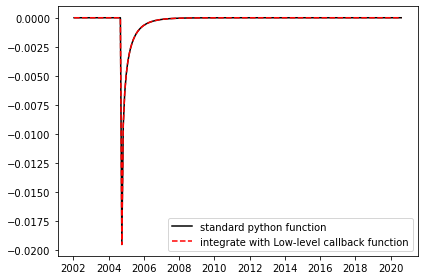

In [7]:
plt.plot(uniform_tvec, y_PF, "k-", label="standard python function")
plt.plot(uniform_tvec, y_PF_llc, "r--", label="integrate with Low-level callback function")
plt.legend()
plt.tight_layout()